In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 150
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchmetrics
import lightning as L
import torchattacks
from torchattacks import VANILA, FGSM, PGD, JSMA, DeepFool

# from Definitions_CIFAR10
from Definitions_CIFAR10 import T, DATA_PATH, MODELS_PATH, FIGURES_PATH, NUM_CLASSES, RANDOM_SEED
from Definitions_CIFAR10 import TEACHER_TO_STUDENTS
from Definitions_CIFAR10 import NORMALIZE_MEAN, NORMALIZE_STD
from Definitions_CIFAR10 import FullNetwork, ReducedNetwork
from Definitions_CIFAR10 import TeacherModel, StudentModel
from Definitions_CIFAR10 import parse_teacher_str, parse_student_str
from Definitions_CIFAR10 import recover_trained_weights
from Definitions_CIFAR10 import get_CIFAR10_loaders, denormalize_imgs
print(f"T = {T}")
print(f"RANDOM_SEED = {RANDOM_SEED}")

# seeding
L.seed_everything(RANDOM_SEED, workers=True)
torch.manual_seed(RANDOM_SEED)

# device info
device = torch.device("cpu")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
print(f"device = {device}")

Seed set to 42


T = 20
RANDOM_SEED = 42
device = mps


<font size=7><b>CPSC471 Project: Robustness Evaluation (CIFAR10)</b></font>

**Ruomu (Felix) Zou**

Here we evaluate the adversarial robustness of all the teacher/student networks.

**Model naming conventions:**
* `{F,R}T_temp{1,T}`: The *{full (larger architecture), reduced (smaller architecture)}* teacher model trained with cross-entropy with softmax temperature *{$1$, $T$ ($T>1$)}*. NOTE: Soft labels are ALWAYS generated with temperatuer $T$ regardless of teacher training temperature.
* `{F,R}S_temp{1,T}_from_{F,R}T_temp{1,T}`: Given a *{full, reduced}* teacher model trained at temperature *{$1$, $T$}*, generate soft labels at temperature $T$ and train a *{full, reduced}* student model at temperature *{$1$, $T$}*.
* Examples:
    * `FS_tempT_from_FT_tempT` represents the student model of the DD paper.
    * `RS_tempT_from_FT_temp1` represents the student model of traditional (Hinton) knowledge distillation.
    * `{F,R}S_temp1_from_{F,R}T_temp1` represents distillation where the only application of temperature is during soft label generation.
    * `{F,R}S_temp1_from_{F,R}T_tempT` represents something unconventional and weird.

# Constants and Configurations:

In [2]:
# inference-specific constants and configurations
BATCH_SIZE = 100

attack_to_name = {
    VANILA:"No Attack",
    FGSM: "Fast Gradient Sign Method",
    PGD: "Projected Gradient Descent",
    JSMA: "Jacobian Saliency Map Attack",
    DeepFool: "Deep Fool"
}

attack_to_name_reduced = {
    VANILA:"No Attack",
    FGSM: "FGSM",
    PGD: "PGD",
    JSMA: "JSMA",
    DeepFool: "DeepFool"
}

# Helper Functions:

In [3]:
def attack_image_and_plot(model_str, attack_method_class, image_idx, dataloader, strong_attack=False):
    """Evaluate the performance of the given model's trained network on the given attack method.

    NOTE: Assumes that the model corresponding to the passed string has been trained and saved already!

    Args:
        model_str: str representing the model.
        attack_method_class: torchattacks attack class.
        image_idx: int, index of the image to attack and plot.
        dataloader: dataloader from which to draw attack images.
        strong_attack: whether to divide the logits by temperature as proposed in CW to counter DD.
    Returns:
        None, displays plot.
    """
    # recover weights
    network = recover_trained_weights(model_str)

    # if using CW's strong attacks, wrap original module to divide logits by T
    if strong_attack:
        class HighTempInferenceWrapper(nn.Module):
            def __init__(self, base_module, inference_temperature):
                super().__init__()
                self.base_module = base_module
                self.inference_temperature = inference_temperature
            def forward(self, x):
                # Just divide base_module's logits by inference_temperature
                return self.base_module(x) / self.inference_temperature
        temp_to_use = T if model_str[7] == "T" else 1
        network = HighTempInferenceWrapper(network, temp_to_use).eval()

    # get image to attack
    img, label = dataloader.dataset[image_idx]
    img = img.unsqueeze(0)
    label = torch.Tensor([label,]).to(int)
    label_name = trainloader.dataset.classes[label]

    # pass clean image through network
    pred = network(img).argmax(-1).item()
    pred_name = trainloader.dataset.classes[pred]

    # get attack
    attack = attack_method_class(network)
    attack.set_normalization_used(mean=[NORMALIZE_MEAN,NORMALIZE_MEAN,NORMALIZE_MEAN],
                                  std=[NORMALIZE_STD,NORMALIZE_STD,NORMALIZE_STD])

    # generate adversarial image and pass through network
    img_adv = attack(img, label)
    pred_adv = network(img_adv).argmax(-1).item()
    pred_adv_name = trainloader.dataset.classes[pred_adv]
    
    # plot
    fig, ax = plt.subplots(1,2,figsize=(10, 6))
    ax[0].imshow(denormalize_imgs(img).squeeze().permute(1,2,0))
    ax[0].set_title(f"Clean Image (Predicted Class '{pred_name}')")
    ax[1].imshow(denormalize_imgs(img_adv).squeeze().permute(1,2,0))
    ax[1].set_title(f"Attacked Image (Predicted Class '{pred_adv_name}')")
    plt.suptitle(f"Image {image_idx} (Label '{label_name}') Attacked Using {attack_to_name[attack_method_class]} {'(CW Strong Version)' if strong_attack else '(Weak Version)'}",
                 fontsize=15, fontweight="bold")
    plt.tight_layout()
    plt.show()

def attack_and_evaluate(model_str, attack_method_class, dataloader, strong_attack=False, topk=1, max_batches=None):
    """Evaluate the performance of the given model's trained network on the given attack method.

    NOTE: Assumes that the model corresponding to the passed string has been trained and saved already!

    Args:
        model_str: str representing the model.
        attack_method_class: torchattacks attack class.
        dataloader: dataloader from which to draw attack images.
        strong_attack: whether to divide the logits by temperature as proposed in CW to counter DD.
        topk: top k used for accuracy.
        max_batches: if None, generate adversarial images for whole dataloader. Otherwise only go for
                     specified number of batches.
    Returns:
        Int, the accuracy of the model's network on the attacked dataloader.
    """
    # recover weights
    network = recover_trained_weights(model_str)

    # if using CW's strong attacks, wrap original module to divide logits by T
    if strong_attack:
        class HighTempInferenceWrapper(nn.Module):
            def __init__(self, base_module, inference_temperature):
                super().__init__()
                self.base_module = base_module
                self.inference_temperature = inference_temperature
            def forward(self, x):
                # Just divide base_module's logits by inference_temperature
                return self.base_module(x) / self.inference_temperature
        temp_to_use = T if model_str[7] == "T" else 1
        network = HighTempInferenceWrapper(network, temp_to_use).eval()

    # get attack
    attack = attack_method_class(network)
    attack.set_normalization_used(mean=[NORMALIZE_MEAN,NORMALIZE_MEAN,NORMALIZE_MEAN],
                                  std=[NORMALIZE_STD,NORMALIZE_STD,NORMALIZE_STD])

    # get accuracy metric
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, top_k=topk)

    # loop through and evaluate each batch
    batch_accuracies = []
    torch.manual_seed(RANDOM_SEED)
    for i, (imgs, labels) in enumerate(dataloader):
        # make sure network is still in eval
        network.eval()
        
        # stop if exceeded max_batches
        if max_batches is not None and i+1 > max_batches:
            break

        # generate adversarial images and pass through network
        imgs_adv = attack(imgs, labels)
        probs_adv = F.softmax(network(imgs_adv), dim=-1)

        # calculate topk accuracy and add to list
        batch_accuracies.append(metric(probs_adv, labels).item())

    # return the mean of the batch accuracies
    return sum(batch_accuracies) / len(batch_accuracies)

def evaluate_all_models(attacks, dataloader, topk=1, max_batches=None):
    """Wrapper for attack_and_evaluate to run on all models."""
    # loop through all teachers
    for teacher, students in TEACHER_TO_STUDENTS.items():
        # first print a single line with all the model names
        print(f"{f'{teacher}:' : <25}", end="")
        for student in students:
            print(f"{f'{student}:' : <25}",end="")
        print() # newline

        # then print one line for each attack
        for attack in attacks:
            
            # attack teacher with weak attack
            acc = attack_and_evaluate(teacher, attack, dataloader, False, topk, max_batches)
            print(f"{f'  * {attack_to_name_reduced[attack]}: {round(acc*100, 2)}%' : <25}",end="")
            # attack all students with weak attack
            for student in students:
                acc = attack_and_evaluate(student, attack, dataloader, False, topk, max_batches)
                print(f"{f'  * {attack_to_name_reduced[attack]}: {round(acc*100, 2)}%' : <25}",end="")
            print() # newline

            if attack is not VANILA:
                # attack teacher again with strong attack
                acc = attack_and_evaluate(teacher, attack, dataloader, True, topk, max_batches)
                print(f"{f'  * {attack_to_name_reduced[attack]} (CW): {round(acc*100, 2)}%' : <25}",end="")
                # attack all students again with strong attack
                for student in students:
                    acc = attack_and_evaluate(student, attack, dataloader, True, topk, max_batches)
                    print(f"{f'  * {attack_to_name_reduced[attack]} (CW): {round(acc*100, 2)}%' : <25}",end="")
                print() # newline
            
        print() # newline

# Execution:

## Get data:

In [4]:
trainloader, testloader = get_CIFAR10_loaders(BATCH_SIZE)

## Evaluate all networks:

In [5]:
# max_batches = 10
# print(f"{f'Attacking All Models on the Training Dataset Using Random Sample of {BATCH_SIZE*max_batches} Datapoints (Top 1 Accuracy)' : ^20}\n")
# evaluate_all_models(attacks=[VANILA], dataloader=trainloader, topk=1, max_batches=max_batches)

Attacking All Models on the Training Dataset Using Random Sample of 1000 Datapoints (Top 1 Accuracy)

RT_temp1:                RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
  * No Attack: 98.8%       * No Attack: 83.4%       * No Attack: 86.3%       * No Attack: 82.8%       * No Attack: 83.8%     

FT_temp1:                RS_temp1_from_FT_temp1:  FS_temp1_from_FT_temp1:  RS_tempT_from_FT_temp1:  FS_tempT_from_FT_temp1:  
  * No Attack: 99.8%       * No Attack: 85.1%       * No Attack: 93.4%       * No Attack: 81.6%       * No Attack: 90.1%     

RT_tempT:                RS_temp1_from_RT_tempT:  FS_temp1_from_RT_tempT:  RS_tempT_from_RT_tempT:  FS_tempT_from_RT_tempT:  
  * No Attack: 87.4%       * No Attack: 84.2%       * No Attack: 85.4%       * No Attack: 80.3%       * No Attack: 84.6%     

FT_tempT:                RS_temp1_from_FT_tempT:  FS_temp1_from_FT_tempT:  RS_tempT_from_FT_tempT:  FS_tempT_from_FT_tempT:  
  * No Attack

In [6]:
# max_batches = 10
# print(f"{f'Attacking All Models on the Testing Dataset Using Random Sample of {BATCH_SIZE*max_batches} Datapoints (Top 1 Accuracy)' : ^20}\n")
# evaluate_all_models(attacks=[VANILA, FGSM, PGD, DeepFool], dataloader=testloader, topk=1, max_batches=max_batches)

Attacking All Models on the Testing Dataset Using Random Sample of 1000 Datapoints (Top 1 Accuracy)

RT_temp1:                RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
  * No Attack: 77.7%       * No Attack: 76.0%       * No Attack: 78.3%       * No Attack: 77.0%       * No Attack: 78.3%     
  * FGSM: 2.7%             * FGSM: 7.5%             * FGSM: 14.0%            * FGSM: 5.8%             * FGSM: 10.5%          
  * FGSM (CW): 2.7%        * FGSM (CW): 7.5%        * FGSM (CW): 14.0%       * FGSM (CW): 10.7%       * FGSM (CW): 12.5%     
  * PGD: 0.0%              * PGD: 0.5%              * PGD: 0.7%              * PGD: 0.6%              * PGD: 0.3%            
  * PGD (CW): 0.0%         * PGD (CW): 0.5%         * PGD (CW): 0.7%         * PGD (CW): 1.0%         * PGD (CW): 1.0%       
  * DeepFool: 3.1%         * DeepFool: 2.5%         * DeepFool: 2.0%         * DeepFool: 2.7%         * DeepFool: 1.9%       
  * DeepFool (CW)

Attacking All Models on the Testing Dataset Using Random Sample of 1000 Datapoints (Top 1 Accuracy)

RT_temp1:                RS_temp1_from_RT_temp1:  FS_temp1_from_RT_temp1:  RS_tempT_from_RT_temp1:  FS_tempT_from_RT_temp1:  
  * No Attack: 77.7%       * No Attack: 76.0%       * No Attack: 78.3%       * No Attack: 77.0%       * No Attack: 78.3%     
  * FGSM: 2.7%             * FGSM: 7.5%             * FGSM: 14.0%            * FGSM: 5.8%             * FGSM: 10.5%          
  * FGSM (CW): 2.7%        * FGSM (CW): 7.5%        * FGSM (CW): 14.0%       * FGSM (CW): 10.7%       * FGSM (CW): 12.5%     
  * PGD: 0.0%              * PGD: 0.5%              * PGD: 0.7%              * PGD: 0.6%              * PGD: 0.3%            
  * PGD (CW): 0.0%         * PGD (CW): 0.5%         * PGD (CW): 0.7%         * PGD (CW): 1.0%         * PGD (CW): 1.0%       
  * DeepFool: 3.1%         * DeepFool: 2.5%         * DeepFool: 2.0%         * DeepFool: 2.7%         * DeepFool: 1.9%       
  * DeepFool (CW): 3.1%    * DeepFool (CW): 2.5%    * DeepFool (CW): 2.0%    * DeepFool (CW): 2.3%    * DeepFool (CW): 1.5%  

FT_temp1:                RS_temp1_from_FT_temp1:  FS_temp1_from_FT_temp1:  RS_tempT_from_FT_temp1:  FS_tempT_from_FT_temp1:  
  * No Attack: 83.4%       * No Attack: 79.0%       * No Attack: 83.6%       * No Attack: 77.6%       * No Attack: 82.2%     
  * FGSM: 9.7%             * FGSM: 5.1%             * FGSM: 10.0%            * FGSM: 9.4%             * FGSM: 8.3%           
  * FGSM (CW): 9.7%        * FGSM (CW): 5.1%        * FGSM (CW): 10.0%       * FGSM (CW): 7.4%        * FGSM (CW): 9.5%      
  * PGD: 0.0%              * PGD: 0.1%              * PGD: 0.0%              * PGD: 0.1%              * PGD: 0.1%            
  * PGD (CW): 0.0%         * PGD (CW): 0.1%         * PGD (CW): 0.0%         * PGD (CW): 0.4%         * PGD (CW): 0.1%       
  * DeepFool: 2.3%         * DeepFool: 3.8%         * DeepFool: 1.0%         * DeepFool: 3.6%         * DeepFool: 1.3%       
  * DeepFool (CW): 2.3%    * DeepFool (CW): 3.8%    * DeepFool (CW): 1.0%    * DeepFool (CW): 3.6%    * DeepFool (CW): 1.1%  

RT_tempT:                RS_temp1_from_RT_tempT:  FS_temp1_from_RT_tempT:  RS_tempT_from_RT_tempT:  FS_tempT_from_RT_tempT:  
  * No Attack: 76.1%       * No Attack: 75.9%       * No Attack: 79.3%       * No Attack: 74.4%       * No Attack: 79.6%     
  * FGSM: 25.1%            * FGSM: 5.6%             * FGSM: 10.6%            * FGSM: 25.6%            * FGSM: 31.7%          
  * FGSM (CW): 3.8%        * FGSM (CW): 5.6%        * FGSM (CW): 10.6%       * FGSM (CW): 5.8%        * FGSM (CW): 10.3%     
  * PGD: 16.4%             * PGD: 0.2%              * PGD: 0.4%              * PGD: 12.1%             * PGD: 8.2%            
  * PGD (CW): 0.4%         * PGD (CW): 0.2%         * PGD (CW): 0.4%         * PGD (CW): 1.0%         * PGD (CW): 0.4%       
  * DeepFool: 3.2%         * DeepFool: 3.1%         * DeepFool: 1.7%         * DeepFool: 3.1%         * DeepFool: 1.5%       
  * DeepFool (CW): 3.9%    * DeepFool (CW): 3.1%    * DeepFool (CW): 1.7%    * DeepFool (CW): 3.8%    * DeepFool (CW): 1.8%  

FT_tempT:                RS_temp1_from_FT_tempT:  FS_temp1_from_FT_tempT:  RS_tempT_from_FT_tempT:  FS_tempT_from_FT_tempT:  
  * No Attack: 84.1%       * No Attack: 78.1%       * No Attack: 84.3%       * No Attack: 77.2%       * No Attack: 84.8%     
  * FGSM: 52.3%            * FGSM: 4.0%             * FGSM: 7.8%             * FGSM: 29.1%            * FGSM: 52.6%          
  * FGSM (CW): 7.3%        * FGSM (CW): 4.0%        * FGSM (CW): 7.8%        * FGSM (CW): 5.0%        * FGSM (CW): 8.0%      
  * PGD: 45.9%             * PGD: 0.2%              * PGD: 0.1%              * PGD: 20.1%             * PGD: 40.9%           
  * PGD (CW): 0.0%         * PGD (CW): 0.2%         * PGD (CW): 0.1%         * PGD (CW): 0.7%         * PGD (CW): 0.1%       
  * DeepFool: 2.8%         * DeepFool: 2.6%         * DeepFool: 2.9%         * DeepFool: 3.9%         * DeepFool: 2.3%       
  * DeepFool (CW): 3.2%    * DeepFool (CW): 2.6%    * DeepFool (CW): 2.9%    * DeepFool (CW): 3.2%    * DeepFool (CW): 2.3%  

## Single image examples:

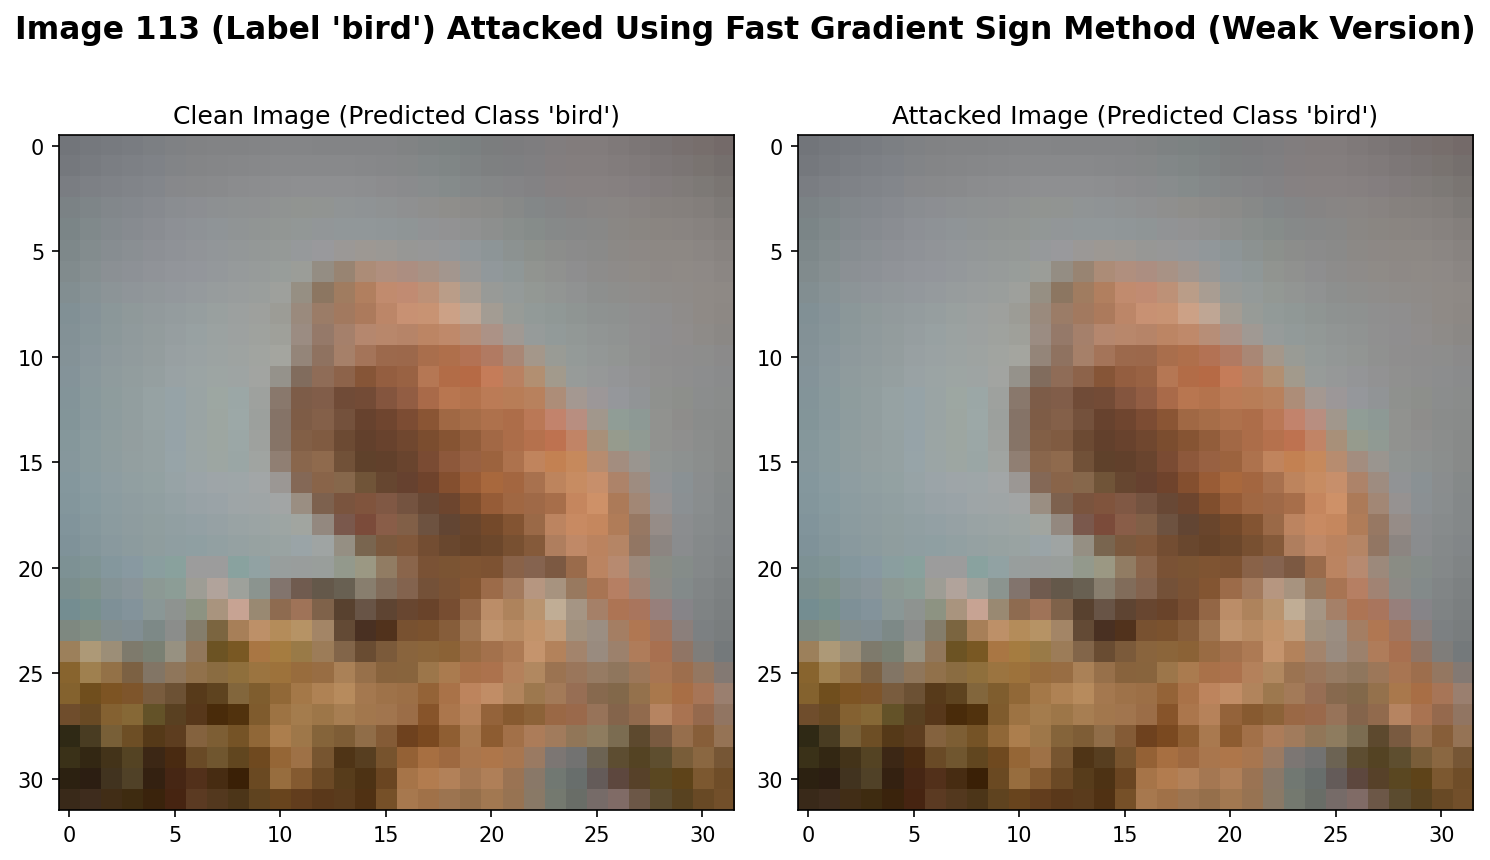

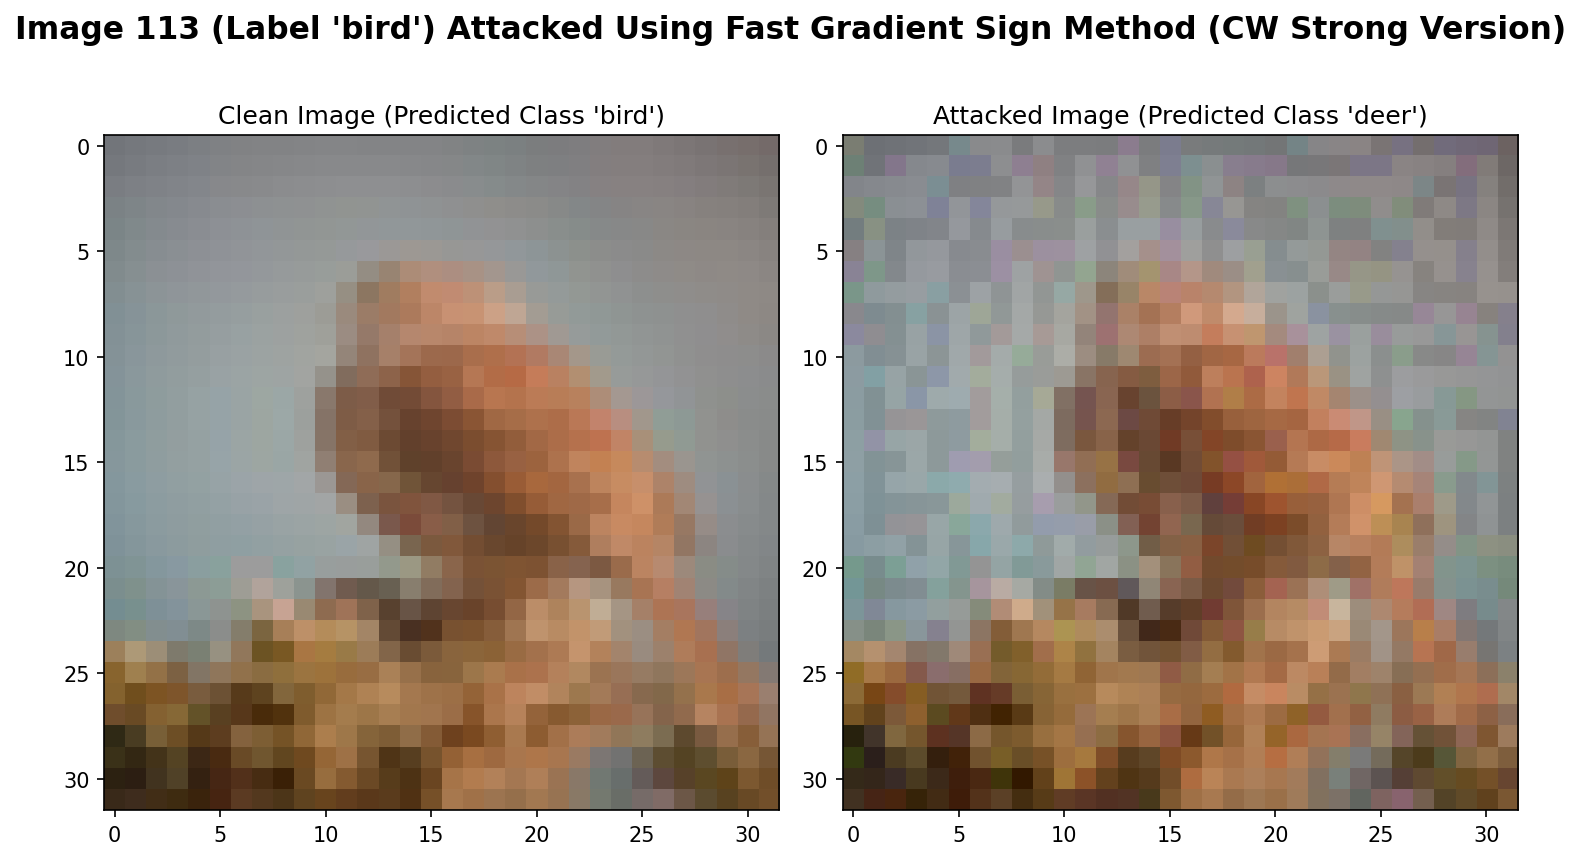

In [18]:
attack_image_and_plot("FS_tempT_from_FT_tempT", FGSM, 113, testloader, strong_attack=False)
attack_image_and_plot("FS_tempT_from_FT_tempT", FGSM, 113, testloader, strong_attack=True)